In [1]:
"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

'\nGenerate data with specified changepoints\nCompare ELBO fits for changepoint model with different\nnumbers of changepoints\n'

In [2]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt

[305 386 534 719]
[   0  305  386  534  719 1000]
[0.87263796 0.21025472 0.31831598 0.29665978 0.08541205]


Text(0, 0.5, 'Firing Rate')

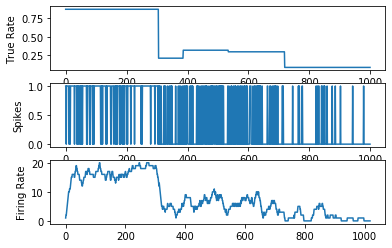

In [8]:
# Some poisson spiking
length = 1000
states = 5
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random(states)

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros(length)
for num, val in enumerate(true_lambda):
    true_r[state_inds[num]:state_inds[num+1]] = val
  
data_vec = np.random.random(length) < true_r
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(3,1)
ax[0].plot(true_r)
ax[1].plot(data_vec)
ax[2].plot(np.convolve(data_vec,np.ones(20)))
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")
ax[2].set_ylabel("Firing Rate")

In [590]:
def create_model(data_vec, states, likelihood_type = 'poisson'):
    with pm.Model() as model:
        lambda_latent = pm.Exponential('lambda', 
                                        1/np.mean(data_vec), 
                                        shape = states,
                                      testval = np.mean(data_vec))

        a = pm.HalfNormal('a_tau', 3., shape = states - 1)
        b = pm.HalfNormal('b_tau', 3., shape = states - 1)
        
        even_switches = np.linspace(0,1,states+1)[1:-1]
        tau_latent = pm.Beta('tau_latent', a, b, 
                             testval = even_switches,
                             shape = (states-1)).sort(axis=-1)
                             

        tau = pm.Deterministic('tau', 
                idx.min() + (idx.max() - idx.min()) * tau_latent)

        # Sigmoing to create transitions based off tau
        # Hardcoded 3-5 states
        weight_1_stack = tt.nnet.sigmoid(idx - tau[0])
        if states > 2:
            weight_2_stack = tt.nnet.sigmoid(idx - tau[1])
        if states > 3:
            weight_3_stack = tt.nnet.sigmoid(idx - tau[2])
        if states > 4:
            weight_4_stack = tt.nnet.sigmoid(idx - tau[3])

        # Generate firing rates from lambda and sigmoid weights
        if states == 2:
            # 3 states
            lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0]) + \
                    np.multiply(weight_1_stack, lambda_latent[1])

            
        if states == 3:
            # 3 states
            lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), 
                            lambda_latent[1]) + \
                    np.multiply(weight_2_stack, 
                                lambda_latent[2])

        elif states == 4:
            # 4 states
            lambda_ = np.multiply(1 - weight_1_stack, 
                            lambda_latent[0]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), 
                            lambda_latent[1]) + \
                    np.multiply(weight_2_stack * (1 - weight_3_stack), 
                            lambda_latent[2]) + \
                    np.multiply(weight_3_stack, 
                                lambda_latent[3])

        elif states == 5:
            # 5 states
            lambda_ = np.multiply(1 - weight_1_stack, 
                            lambda_latent[0]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), 
                            lambda_latent[1]) + \
                    np.multiply(weight_2_stack * (1 - weight_3_stack), 
                            lambda_latent[2]) +\
                    np.multiply(weight_3_stack * (1 - weight_4_stack), 
                            lambda_latent[3])+ \
                    np.multiply(weight_4_stack, 
                            lambda_latent[4])

        # Add observations
        if likelihood_type == 'poisson':
            observation = pm.Poisson("obs", lambda_, observed=data_vec)
        elif likelihood_type == 'bernoulli':
            observation = pm.Bernoulli("obs", lambda_, observed=data_vec)
    return model

In [591]:
num_states = np.arange(2,6)
print(num_states)
model_list = [create_model(data_vec, state_num) \
              for state_num in num_states]

INFO (theano.gof.compilelock): Refreshing lock /home/abuzarmahmood/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.10-64/lock_dir/lock


[2 3 4 5]


In [602]:
def fit_model(model,fit,samples):
    with model:
        inference = pm.ADVI('full-rank')
        #inference = pm.ADVI('mean-field')
        approx = pm.fit(n=fit, method=inference,
                        callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute',tolerance=2e-4)],
                       random_seed = 3)
        trace = approx.sample(draws=samples)
    return approx,trace

In [603]:
fit_list = [fit_model(this_model,fit,samples) for this_model in model_list]

Average Loss = 187.65: 100%|██████████| 100000/100000 [00:27<00:00, 3598.59it/s]
Finished [100%]: Average Loss = 187.65
Average Loss = 189.57: 100%|██████████| 100000/100000 [00:29<00:00, 3393.03it/s]
Finished [100%]: Average Loss = 189.58
Average Loss = 185.76: 100%|██████████| 100000/100000 [00:30<00:00, 3264.24it/s]
Finished [100%]: Average Loss = 185.76
Average Loss = 186.59: 100%|██████████| 100000/100000 [00:32<00:00, 3074.45it/s]
Finished [100%]: Average Loss = 186.6


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


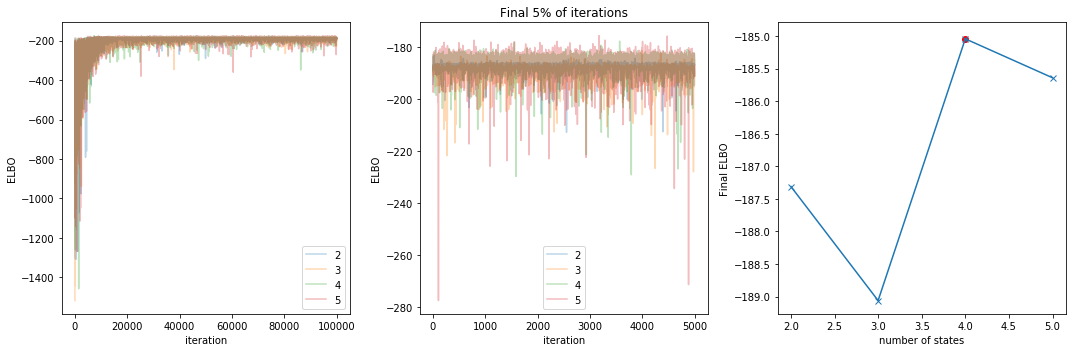

In [604]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for num, this_fit in enumerate(fit_list):
    ax[0].plot(-this_fit[0].hist, label=num_states[num], alpha=.3)
ax[0].legend()
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
for num, this_fit in enumerate(fit_list):
    ax[1].plot(-this_fit[0].hist[ind:], label=num_states[num], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].legend()
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

# Plot final value
fin_elbo = [np.median(-x[0].hist[ind:],axis=None) for x in fit_list]
ax[2].plot(num_states,fin_elbo,'-x');
max_elbo = np.max(fin_elbo)
ax[2].scatter(num_states[np.where(fin_elbo == max_elbo)[0]],max_elbo,c='red');
ax[2].set_ylabel('Final ELBO')
ax[2].set_xlabel('number of states');
plt.tight_layout()
fig.savefig(f'{states}_state_elbo')

In [605]:
ppc_list = [pm.sample_posterior_predictive(this_fit[1], samples = 2000, model = this_model) \
            for this_fit, this_model in zip(fit_list,model_list)]

100%|██████████| 2000/2000 [00:01<00:00, 1176.74it/s]


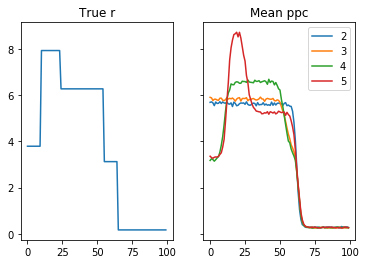

In [606]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
for num, this_ppc in enumerate(ppc_list):
    ax[1].plot(np.mean(this_ppc['obs'],axis=0), label=num_states[num], alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean ppc')
plt.legend()
fig.savefig(f'{states}_state_ppc')

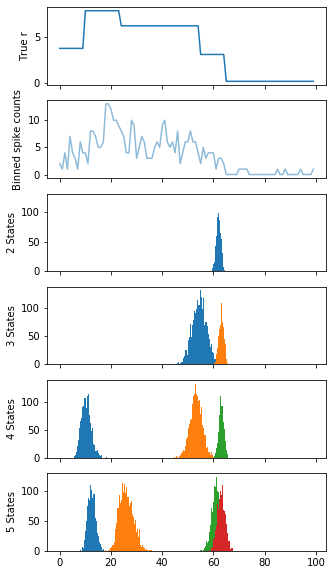

In [607]:
tau_list = [this_fit[1]['tau'] for this_fit in fit_list]
fig,ax = plt.subplots(2+len(tau_list),1,sharex=True,figsize=(5,10))
ax[0].plot(true_r)
ax[0].set_ylabel('True r')
ax[1].plot(data_vec,alpha = 0.5)
ax[1].set_ylabel('Binned spike counts')
for num, this_fit in enumerate(tau_list):
    for this_tau in this_fit.T:
        ax[2+num].hist(this_tau,bins=50)
        ax[2+num].set_ylabel(f'{num_states[num]} States')
fig.savefig(f'{states}_state_tau_hists')